In [141]:
import nbdHelp as ndb
import ndbDELETE as ndb2
from functools import partial

import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import scipy.ndimage
from scipy.spatial import Voronoi, voronoi_plot_2d

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import math
from collections import defaultdict
import numpy as np

import io
import base64
from IPython.display import HTML, display
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter

from PIL import Image
rc('animation', html='jshtml')


In [142]:
in_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/df_in.parquet'
out_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/df_out.parquet'
sup_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/sup_file.parquet'

df_in = pd.read_parquet(in_path)
df_out = pd.read_parquet(out_path)
sup_file = pd.read_parquet(sup_path)
map_file= pd.read_parquet('/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/mapping_df.parquet')

print('Loaded df_in:', df_in.shape)
print('Loaded df_out:', df_out.shape)
print('Loaded sup_file:', sup_file.shape)
print('Loaded map_file:', map_file.shape)

Loaded df_in: (4880579, 24)
Loaded df_out: (562936, 7)
Loaded sup_file: (18009, 42)
Loaded map_file: (14108, 5)


In [143]:
print(df_in.columns.tolist())
print(df_out.columns.tolist())
print(sup_file.columns.tolist())

['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'flat_play_id']
['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y', 'flat_play_id']
['game_id', 'season', 'week', 'game_date', 'game_time_eastern', 'home_team_abbr', 'visitor_team_abbr', 'play_id', 'play_description', 'quarter', 'game_clock', 'down', 'yards_to_go', 'possession_team', 'defensive_team', 'yardline_side', 'yardline_number', 'pre_snap_home_score', 'pre_snap_visitor_score', 'play_nullified_by_penalty', 'pass_result', 'pass_length', 'offense_formation', 'receiver_alignment', 'route_of_targeted_receiver', 'play_action', 'dropback_type', 'dropback_distance', 'pass_location_type', 'defenders_in_the_box', 'team_coverage_man_zone', 'team_coverage_type', 'penalty_yards',

In [144]:
# Merge df_out with df_in to get player_role for each row
df_out_merged = df_out.merge(df_in[['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_role','ball_land_x', 'ball_land_y']],
                      on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
                      how='left')

In [145]:
from scipy.ndimage import gaussian_filter

def drawLine(pt0,pt1,n):

    pt0 = np.asarray(pt0, dtype=float)
    pt1 = np.asarray(pt1, dtype=float)

    if n <= 0:
        pts = np.empty((0, 2))
        return pts

    if n == 1:
        pts = np.array([(pt0 + pt1) / 2.0])
        return pts

    xs = np.linspace(pt0[0], pt1[0], num=n)
    ys = np.linspace(pt0[1], pt1[1], num=n)
    pts = np.column_stack((xs, ys))

    return pts



def interpolate_value(arr, coord):
    """
    Bilinear interpolation on 2D array `arr`.
    coord is (x, y) in pixel coordinates where x is column index and y is row index.
    Returns interpolated scalar (float). If coord is outside array bounds returns np.nan.
    Handles NaNs in neighbors by renormalizing weights over available neighbors.
    """
    arr = np.asarray(arr, dtype=float)
    if arr.ndim != 2:
        raise ValueError("arr must be 2D")

    x, y = tuple(np.asarray(coord).astype(float).ravel()[:2])

    h, w = arr.shape
    # Outside bounds -> return nan
    if x < 0 or x > (w - 1) or y < 0 or y > (h - 1):
        return np.nan

    x0 = int(np.floor(x))
    y0 = int(np.floor(y))
    x1 = min(x0 + 1, w - 1)
    y1 = min(y0 + 1, h - 1)

    # fractional parts
    wx = x - x0
    wy = y - y0

    # Neighbor values
    Ia = arr[y0, x0]  # top-left
    Ib = arr[y0, x1]  # top-right
    Ic = arr[y1, x0]  # bottom-left
    Id = arr[y1, x1]  # bottom-right

    # Bilinear weights
    wa = (1 - wx) * (1 - wy)
    wb = wx * (1 - wy)
    wc = (1 - wx) * wy
    wd = wx * wy

    neighbors = np.array([Ia, Ib, Ic, Id], dtype=float)
    weights = np.array([wa, wb, wc, wd], dtype=float)

    # Mask out NaNs and zero-weight neighbors (possible when x0==x1 or y0==y1)
    valid = ~np.isnan(neighbors) & (weights > 0)
    if not valid.any():
        # If none of the weighted neighbors are valid, try averaging any non-NaN neighbors nearby
        vals = neighbors[~np.isnan(neighbors)]
        return float(vals.mean()) if vals.size > 0 else np.nan

    weights = weights * valid.astype(float)
    total_w = weights.sum()
    if total_w == 0:
        return np.nan

    return float((weights * neighbors).sum() / total_w)

def get_Image(id,path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/CSD_database/_'):
    #Get CSD for a given id

    CSD = Image.open(f"{path}{id}.png").convert('L')
    CSD_array = np.array(CSD)

    # scale pixels so 0 -> 0 and 255 -> 1
    CSD_array = CSD_array.astype(float) / 255.0

    # smooth the CSD with a Gaussian kernel (adjust sigma as needed)
    sigma = 1
    CSD_array = gaussian_filter(CSD_array.astype(float), sigma=sigma)
    CSD_array = np.clip(CSD_array, 0, 255)
    center_x, center_y = CSD_array.shape[1] // 2, CSD_array.shape[0] // 2

    return CSD_array, center_x,center_y

def getBestPath(Image):
    CSD_array, center_x,center_y = Image

    CSD_array, center_x, center_y = Image
    h, w = CSD_array.shape
    
    n=20
    top_left = (0.0, 0.0)
    top_right = (w - 1.0, 0.0)
    bottom_left = (0.0, h - 1.0)
    bottom_right = (w - 1.0, h - 1.0)


    # convert corner tuples to numpy arrays for vectorized arithmetic
    tl = np.asarray(top_left, dtype=float)
    tr = np.asarray(top_right, dtype=float)
    bl = np.asarray(bottom_left, dtype=float)
    br = np.asarray(bottom_right, dtype=float)

    # create line segments: midpoint -> corner for top and bottom, full right edge
    ptstop = drawLine((tl + tr) / 2.0, tr, n // 2)
    ptsbot = drawLine((bl + br) / 2.0, br, n // 2)
    ptsrig = drawLine(br, tr, n)
    
    parts = []
    for name in ('ptstop', 'ptsrig', 'ptsbot'):
        try:
            arr = np.asarray(locals()[name], dtype=float)
            if arr.size:
                parts.append(arr)
        except Exception:
            # skip if name not defined or cannot be converted
            continue
    
    pts = np.vstack(parts) if parts else np.empty((0, 2), dtype=float)

    val=[]
    for endpt in pts:
        pathpts=drawLine((center_x,center_y),endpt,20)
        val.append(np.mean(get_vals(Image,pathpts)))
    
    vals_arr = np.asarray(val, dtype=float)
    best_idx = int(np.nanargmax(vals_arr))

    best_pt = pts[best_idx] if best_idx is not None else None


    # # display the CSD and overlay the sampled points
    # fig, ax = plt.subplots(figsize=(6, 6))
    # im = ax.imshow(CSD_array, cmap='gray', origin='upper', vmin=CSD_array.min(), vmax=CSD_array.max())
    # # plot sampled points if any
    # if pts.size:
    #     ax.scatter(pts[:, 0], pts[:, 1], c='red', s=25, label='pts')
    # # mark image center
    # ax.scatter([center_x], [center_y], c='cyan', marker='x', s=60, label='center')
    # ax.scatter(best_pt[0],best_pt[1],c='green')
    # ax.set_xlim(0, w - 1)
    # ax.set_ylim(h - 1, 0)  # match array indexing with origin='upper'
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_title('CSD_array with sampled points')
    # ax.legend(loc='upper right')
    # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # plt.show()

    return best_pt

def get_vals(Image,pts):
    CSD_array, center_x,center_y = Image
    vals = []
    for pt in pts:
        vals.append(interpolate_value(CSD_array,pt))
    return vals

def getValue(id):
    Image=get_Image(id)
    CSD_array, center_x,center_y = Image
    endpt=getBestPath(Image)
    pts=drawLine((center_x,center_y),endpt,20)
    vals=get_vals(Image,pts)
    return np.mean(vals)

    


In [146]:
getBestPath(get_Image(5))
print(getValue(5))

0.34452782970428925


In [148]:
range = np.arange(0,6389,1)
path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/CSD_database_2/_'
avg_values = [getValue(id) for id in range]

#Calculate YAC

# build mapping from flat_play_id to YAC without reindexing
sup_unique = sup_file.drop_duplicates('flat_play_id').set_index('flat_play_id')
yac_map = (sup_unique['pre_penalty_yards_gained'] - sup_unique['pass_length']).to_dict()
yac_values = [yac_map.get(int(fid), np.nan) for fid in range]

pass_map = sup_file.drop_duplicates('flat_play_id').set_index('flat_play_id')['pass_result'].to_dict()
pass_results = [pass_map.get(int(fid), None) for fid in range]
arr = np.array(pass_results)
# Convert arr to numeric: 1 if 'C', otherwise 0
arr = np.where(arr == 'C', 1, 0).astype(int)

# sanity check lengths
assert len(range) == len(avg_values) == len(yac_values) == len(arr), "Length mismatch between inputs"

df_combined = pd.DataFrame({
    'flat_play_id': range,
    'avg_value': avg_values,
    'yac_value': yac_values,
    'pass_completed': arr
})

display(df_combined.head())


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/CSD_database/_3043.png'

In [ ]:
# keep only completed passes (pass_completed == 1)
df_combined = df_combined[df_combined['pass_completed'] == 1].reset_index(drop=True)

print("Filtered df_combined shape:", df_combined.shape)
display(df_combined.head())
df_combined = df_combined[~df_combined['avg_value'].isin([0, 1])].reset_index(drop=True)
print("After dropping avg_value == 0 or 255:", df_combined.shape)
display(df_combined.head())
df_combined['yac_clipped'] = df_combined['yac_value'].clip(0, 1)
display(df_combined[['flat_play_id', 'avg_value', 'yac_value', 'yac_clipped']].head())

Filtered df_combined shape: (1409, 8)


,flat_play_id,avg_value,yac_value,pass_completed,yac_clipped,pred_proba,pred,avg_bin
0,1,0.329539,4,1,1,0.484955,0,0.30000000000000004-0.35000000000000003
1,2,0.467947,1,1,1,0.647450,1,0.45-0.5
2,3,0.384189,0,1,0,0.550720,1,0.35000000000000003-0.4
3,4,0.544892,7,1,1,0.726958,1,0.5-0.55
4,5,0.344528,8,1,1,0.503036,1,0.30000000000000004-0.35000000000000003


After dropping avg_value == 0 or 255: (1269, 8)


,flat_play_id,avg_value,yac_value,pass_completed,yac_clipped,pred_proba,pred,avg_bin
0,1,0.329539,4,1,1,0.484955,0,0.30000000000000004-0.35000000000000003
1,2,0.467947,1,1,1,0.647450,1,0.45-0.5
2,3,0.384189,0,1,0,0.550720,1,0.35000000000000003-0.4
3,4,0.544892,7,1,1,0.726958,1,0.5-0.55
4,5,0.344528,8,1,1,0.503036,1,0.30000000000000004-0.35000000000000003


,flat_play_id,avg_value,yac_value,yac_clipped
0,1,0.329539,4,1
1,2,0.467947,1,1
2,3,0.384189,0,0
3,4,0.544892,7,1
4,5,0.344528,8,1


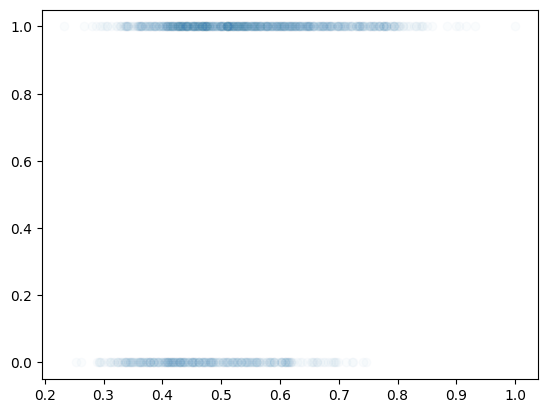

In [ ]:
plt.scatter(df_combined['avg_value'], df_combined['yac_clipped'], alpha=0.02)


In [ ]:
# train a logistic regression using avg_value to predict arr
X = df_combined[['avg_value']].values
y = df_combined['yac_clipped'].values

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
coef = float(model.coef_[0][0])
intercept = float(model.intercept_[0])

print(f"Logit(p) = {intercept:.6f} + {coef:.6f} * avg_value")
print(f"p(avg_value) = 1 / (1 + exp(-({intercept:.6f} + {coef:.6f} * avg_value)))")
print(f"Odds ratio per 1-unit increase in avg_value: {np.exp(coef):.6f}")

if coef != 0:
    decision_boundary = -intercept / coef
    print(f"Decision boundary (p=0.5) at avg_value = {decision_boundary:.4f}")
else:
    print("Coefficient is zero; no decision boundary.")

# attach predictions back to df_summary
df_combined = df_combined.copy()
df_combined['pred_proba'] = model.predict_proba(df_combined[['avg_value']].values)[:, 1]
df_combined['pred'] = (df_combined['pred_proba'] >= 0.5).astype(int)

Accuracy: 0.6889763779527559
ROC AUC: 0.6354895104895105
Confusion matrix:
 [[  4  74]
 [  5 171]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      0.05      0.09        78
           1       0.70      0.97      0.81       176

    accuracy                           0.69       254
   macro avg       0.57      0.51      0.45       254
weighted avg       0.62      0.69      0.59       254

Logit(p) = -1.442885 + 4.360768 * avg_value
p(avg_value) = 1 / (1 + exp(-(-1.442885 + 4.360768 * avg_value)))
Odds ratio per 1-unit increase in avg_value: 78.317258
Decision boundary (p=0.5) at avg_value = 0.3309


/var/folders/y_/lhp104kx7f177lpvvd4rn5pw0000gn/T/ipykernel_44510/3118962730.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df_combined.groupby('avg_bin')['yac_clipped'].agg(


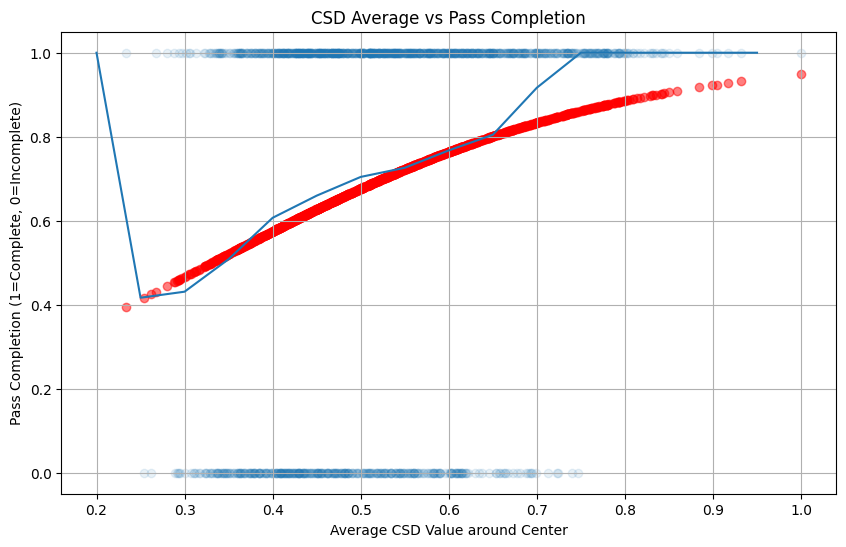

In [ ]:
plt.figure(figsize=(10,6))

bin_size=0.05
bins = np.arange(0, 1 + bin_size, bin_size)
labels = [f"{b}-{b+bin_size}" for b in bins[:-1]]
df_combined['avg_bin'] = pd.cut(df_combined['avg_value'], bins=bins, labels=labels, right=False)

bin_stats = df_combined.groupby('avg_bin')['yac_clipped'].agg(
    count='count',
    pct_1=lambda x: x.mean() * 100
).reset_index()
bin_stats['pct_0'] = 100 - bin_stats['pct_1']

plt.plot(bins[0:-1],bin_stats['pct_1']/100)

plt.scatter(df_combined['avg_value'], df_combined['yac_clipped'], alpha=0.1)
plt.scatter(df_combined['avg_value'], df_combined['pred_proba'], color='red', alpha=0.5)
plt.xlabel('Average CSD Value around Center')
plt.ylabel('Pass Completion (1=Complete, 0=Incomplete)')
plt.title('CSD Average vs Pass Completion')
plt.grid()